# Portfolio Analysis  

## Description

In [1]:
#This portfolio is to run a scenario, where the investor is focusing not only in stock investment, but also on crypto investment. 
#The analysis will run different scenarios, including: portfolio of crypto only, portfolio of crypto/ASX stocks mix
#The result will be used to compare its performance on traditional equity indices such as: ASX20, ASX200, ASX300; or index-tracking ETFs.



## Initial Imports

In [2]:
import datetime as dt
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import os
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from MCForecastTools import MCSimulation



%matplotlib inline

## Getting the Data for Crypto

In [3]:
btc_returns_csv = Path(r"E:\OneDrive\Documents\GitHub\MonashFintech2021Project1\Financial Modelling\Crypto Portfolio\Resources\BTC-USD.csv")
BTC_daily_returns = pd.read_csv(btc_returns_csv, index_col="Date", parse_dates=True, infer_datetime_format=True)
BTC_daily_returns.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], axis=1,inplace=True)
BTC_daily_returns = BTC_daily_returns.rename(columns={"Adj Close":"BTC/USD"})
BTC_daily_returns = BTC_daily_returns["2016-01-01":]
BTC_daily_returns

,BTC/USD
Date,
2016-01-01,434.334015
2016-01-02,433.437988
2016-01-03,430.010986
2016-01-04,433.091003
2016-01-05,431.959991
...,...
2021-04-04,58758.554688
2021-04-05,59057.878906
2021-04-06,58192.359375


In [4]:
eth_returns_csv = Path(r"E:\OneDrive\Documents\GitHub\MonashFintech2021Project1\Financial Modelling\Crypto Portfolio\Resources\ETH-USD.csv")
ETH_daily_returns = pd.read_csv(eth_returns_csv, index_col="Date", parse_dates=True, infer_datetime_format=True)
ETH_daily_returns.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], axis=1,inplace=True)
ETH_daily_returns = ETH_daily_returns.rename(columns={"Adj Close":"ETH/USD"})
ETH_daily_returns = ETH_daily_returns["2016-01-01":]
ETH_daily_returns

,ETH/USD
Date,
2016-01-01,0.948024
2016-01-02,0.937124
2016-01-03,0.971905
2016-01-04,0.954480
2016-01-05,0.950176
...,...
2021-04-04,2093.122803
2021-04-05,2107.887207
2021-04-06,2118.378906


### Extras: Exchange Rate: USD to AUD

In [5]:
exchange_data_csv = Path(r"E:\OneDrive\Documents\GitHub\MonashFintech2021Project1\Financial Modelling\Crypto Portfolio\Resources\AUDUSD=X.csv")
daily_fx_rate = pd.read_csv(exchange_data_csv, index_col="Date", parse_dates=True, infer_datetime_format=True)
daily_fx_rate.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], axis=1,inplace=True)
daily_fx_rate = daily_fx_rate.rename(columns={"Adj Close":"AUD-USD"})
daily_fx_rate = daily_fx_rate["2016-01-01":]
daily_fx_rate

,AUD-USD
Date,
2016-01-01,0.727167
2016-01-04,0.728704
2016-01-05,0.718597
2016-01-06,0.716281
2016-01-07,0.708015
...,...
2021-04-02,0.761900
2021-04-05,0.762100
2021-04-06,0.765873


## Quantitative Analysis 

### Combine Data

In [6]:
crypto_df = pd.concat([
    BTC_daily_returns ,
    ETH_daily_returns ,
     
],axis="columns",join="inner")
crypto_df


,BTC/USD,ETH/USD
Date,,
2016-01-01,434.334015,0.948024
2016-01-02,433.437988,0.937124
2016-01-03,430.010986,0.971905
2016-01-04,433.091003,0.954480
2016-01-05,431.959991,0.950176
...,...,...
2021-04-04,58758.554688,2093.122803
2021-04-05,59057.878906,2107.887207
2021-04-06,58192.359375,2118.378906


### Calculate Returns, Mean, Standard Deviation 

In [7]:
# Define function to calculate returns, volatility
def portfolio_annualized_performance(weights, crypto_means, crypto_cov_matrix):
    crypto_returns = np.sum(crypto_means*weights ) *252
    crypto_std = np.sqrt(np.dot(weights.T, np.dot(crypto_cov_matrix, weights))) * np.sqrt(252)
    return crypto_std, crypto_returns

In [8]:
#Calculate daily returns
crypto_returns = crypto_df.pct_change()
crypto_returns

,BTC/USD,ETH/USD
Date,,
2016-01-01,NaN,NaN
2016-01-02,-0.002063,-0.011498
2016-01-03,-0.007907,0.037115
2016-01-04,0.007163,-0.017929
2016-01-05,-0.002611,-0.004509
...,...,...
2021-04-04,0.020045,0.031897
2021-04-05,0.005094,0.007054
2021-04-06,-0.014655,0.004977


Text(0, 0.5, 'daily returns')

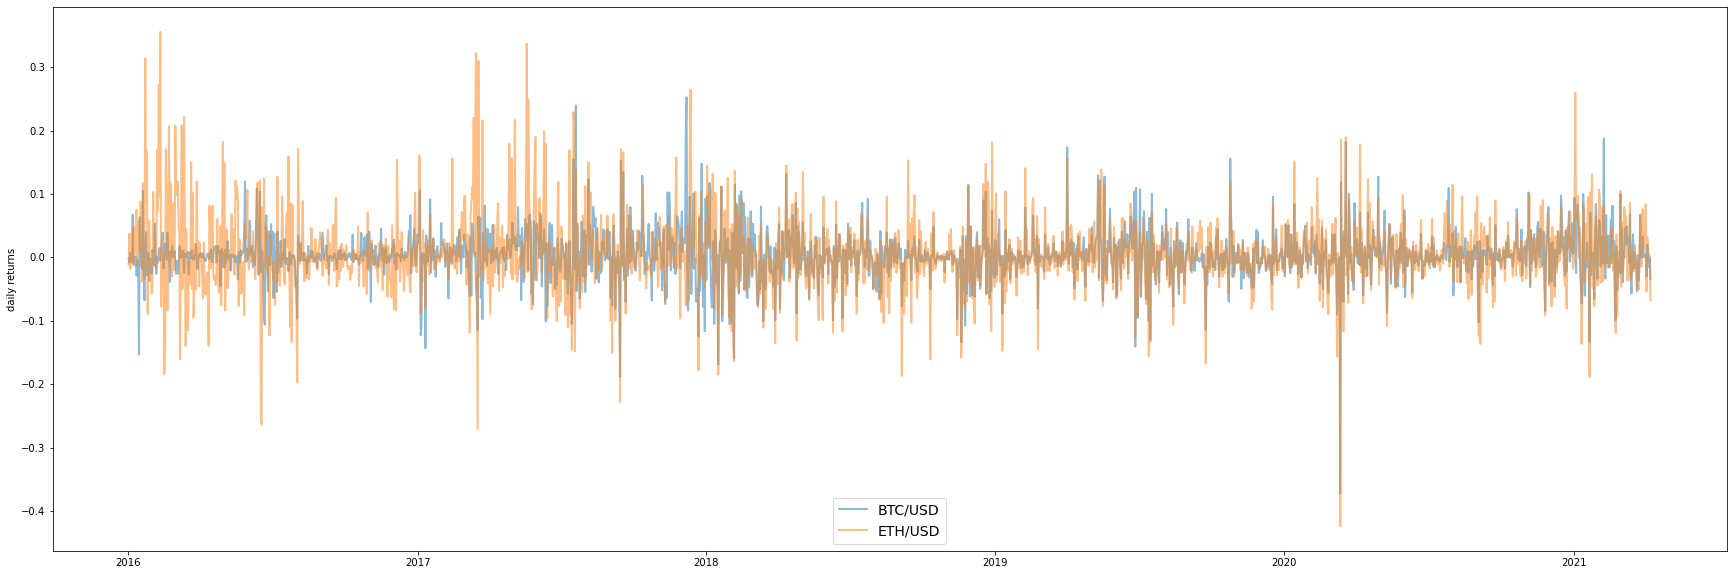

In [9]:
plt.figure(figsize=(30, 10))
for i in crypto_returns.columns.values:
    plt.plot(crypto_returns.index, crypto_returns[i], lw=2, alpha=0.5,label=i)
plt.legend(loc='lower center', fontsize=14)
plt.ylabel('daily returns')

In [10]:
#Calculate means
crypto_means = crypto_df.mean()
crypto_means

BTC/USD    8149.264033
ETH/USD     308.601623
dtype: float64

In [11]:
#Calculate Standard Deviation
crypto_std = crypto_df.std()
crypto_std

BTC/USD    10167.469318
ETH/USD      376.449510
dtype: float64

In [12]:
#Calculate Covariance Matrix
crypto_cov_matrix = crypto_returns.cov()
crypto_cov_matrix

,BTC/USD,ETH/USD
BTC/USD,0.001566,0.001266
ETH/USD,0.001266,0.003522


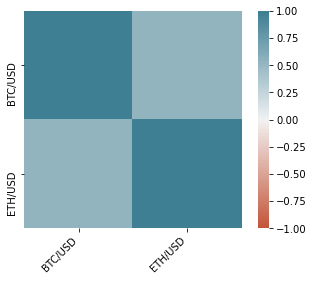

In [13]:
# Plot the correlation heatmap
crypto_corr = crypto_returns.corr()
ax = sns.heatmap(
    crypto_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [17]:
#   So what is happening to this formula? 
#   Before we dive in, we need to understand the concept of max Sharpe Ratio: 
##  The ratio is commonly used as a means of calculating the performance of an investment after 
##  adjusting for its risk that allows investments of different risk profiles to be compared against each other.
##  Max Sharpe Ratio means that investor will choose to go with higher risk, as in this case is Bitcoin, to achieve higher return
##  The volatility gap between Bitcoin and Ethereum is significantly difference with Bitcoin volatility level is over the cloud, 
##  therefore we can see why this model choose to go all-in in Bitcoin instead of allocating a *significant portion* to Ethereum
##  


# Scenario Analysis

## 1st Scenario: Adding Stocks into the Portfolio to determine the mixed portfolio allocation

In [18]:
# in this scenario, we will pick the WAAAX shares, referring to a group of five high-growth ASX technology shares
# they include: WiseTech Global Ltd (ASX: WTC), Afterpay Ltd (ASX: APT), Appen Ltd (ASX: APX), Altium Limited (ASX: ALU), and Xero Limited (ASX: XRO).
# we will run this scenario to examine the affect of a mix crypto/stocks portfolio

### Importing Data

In [19]:
alu_returns_csv = Path(r"E:\OneDrive\Documents\GitHub\MonashFintech2021Project1\Financial Modelling\Crypto Portfolio\Resources\ALU.AX.csv")
alu_daily_returns = pd.read_csv(alu_returns_csv, index_col="Date", parse_dates=True, infer_datetime_format=True)
alu_daily_returns.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], axis=1,inplace=True)
alu_daily_returns = alu_daily_returns.rename(columns={"Adj Close":"ALTIUM"})
alu_daily_returns = alu_daily_returns["2016-01-01":]

In [20]:
apt_returns_csv = Path(r"E:\OneDrive\Documents\GitHub\MonashFintech2021Project1\Financial Modelling\Crypto Portfolio\Resources\APT.AX.csv")
apt_daily_returns = pd.read_csv(apt_returns_csv, index_col="Date", parse_dates=True, infer_datetime_format=True)
apt_daily_returns.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], axis=1,inplace=True)
apt_daily_returns = apt_daily_returns.rename(columns={"Adj Close":"AFTERPAY"})
apt_daily_returns = apt_daily_returns["2016-01-01":]

In [21]:
apx_returns_csv = Path(r"E:\OneDrive\Documents\GitHub\MonashFintech2021Project1\Financial Modelling\Crypto Portfolio\Resources\APX.AX.csv")
apx_daily_returns = pd.read_csv(apx_returns_csv, index_col="Date", parse_dates=True, infer_datetime_format=True)
apx_daily_returns.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], axis=1,inplace=True)
apx_daily_returns = apx_daily_returns.rename(columns={"Adj Close":"APPEN"})
apx_daily_returns = apx_daily_returns["2016-01-01":]

In [22]:
wtc_returns_csv = Path(r"E:\OneDrive\Documents\GitHub\MonashFintech2021Project1\Financial Modelling\Crypto Portfolio\Resources\WTC.AX.csv")
wtc_daily_returns = pd.read_csv(wtc_returns_csv, index_col="Date", parse_dates=True, infer_datetime_format=True)
wtc_daily_returns.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], axis=1,inplace=True)
wtc_daily_returns = wtc_daily_returns.rename(columns={"Adj Close":"WISETECH"})
wtc_daily_returns = wtc_daily_returns["2016-01-01":]

In [23]:
xro_returns_csv = Path(r"E:\OneDrive\Documents\GitHub\MonashFintech2021Project1\Financial Modelling\Crypto Portfolio\Resources\XRO.AX.csv")
xro_daily_returns = pd.read_csv(xro_returns_csv, index_col="Date", parse_dates=True, infer_datetime_format=True)
xro_daily_returns.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], axis=1,inplace=True)
xro_daily_returns = xro_daily_returns.rename(columns={"Adj Close":"XERO"})
xro_daily_returns = xro_daily_returns["2016-01-01":]

In [24]:
# Combined stocks with crypto
mixed1_df = pd.concat([
    crypto_returns,
    alu_daily_returns,
    apt_daily_returns,
    apx_daily_returns,
    wtc_daily_returns,
    xro_daily_returns
     
],axis="columns",join="inner")


,BTC/USD,ETH/USD,ALTIUM,AFTERPAY,APPEN,WISETECH,XERO
Date,,,,,,,
2017-06-29,-0.013776,-0.076371,8.391514,2.700000,3.912474,6.990038,24.650000
2017-06-30,-0.023030,-0.026304,8.135212,2.950000,3.902693,6.870891,24.190001
2017-07-03,0.022977,-0.017671,8.002314,3.000000,3.902693,6.602807,24.000000
2017-07-04,0.014656,-0.033917,8.087749,3.000000,3.912474,6.602807,24.200001
2017-07-05,0.000135,-0.016571,7.973835,3.180000,3.990724,6.841104,24.480000
...,...,...,...,...,...,...,...
2021-03-31,0.000019,0.039180,26.469999,101.500000,15.830000,29.049999,126.529999
2021-04-01,0.003004,0.030711,26.780001,105.519997,16.379999,29.559999,130.869995
2021-04-06,-0.014655,0.004977,27.240000,116.040001,16.580000,31.090000,135.000000


### Calculate Returns, Mean, Standard Deviation

In [26]:
#Calculate daily returns
mixed1_returns = mixed1_df.pct_change()
mixed1_returns

,BTC/USD,ETH/USD,ALTIUM,AFTERPAY,APPEN,WISETECH,XERO
Date,,,,,,,
2017-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-30,0.671748,-0.655576,-0.030543,0.092593,-0.002500,-0.017045,-0.018661
2017-07-03,-1.997690,-0.328203,-0.016336,0.016949,0.000000,-0.039017,-0.007855
2017-07-04,-0.362116,0.919360,0.010676,0.000000,0.002506,0.000000,0.008333
2017-07-05,-0.990818,-0.511410,-0.014085,0.060000,0.020000,0.036090,0.011570
...,...,...,...,...,...,...,...
2021-03-31,-0.999042,1.705859,0.016513,0.004652,-0.030618,0.031972,0.007244
2021-04-01,154.154531,-0.216165,0.011711,0.039606,0.034744,0.017556,0.034300
2021-04-06,-5.879074,-0.837929,0.017177,0.099697,0.012210,0.051759,0.031558


In [27]:
#Calculate means
mixed1_means = mixed1_df.mean()
mixed1_means

BTC/USD      0.003748
ETH/USD      0.001913
ALTIUM      26.353309
AFTERPAY    35.309049
APPEN       19.060242
WISETECH    20.573811
XERO        64.396061
dtype: float64

In [28]:
#Calculate Standard Deviation
mixed1_std = mixed1_df.std()
mixed1_std

BTC/USD      0.045837
ETH/USD      0.055953
ALTIUM       8.899713
AFTERPAY    36.618662
APPEN        9.556712
WISETECH     7.710042
XERO        32.353514
dtype: float64

In [29]:
#Calculate Covariance Matrix
mixed1_cov_matrix = mixed1_returns.cov()
mixed1_cov_matrix

,BTC/USD,ETH/USD,ALTIUM,AFTERPAY,APPEN,WISETECH,XERO
BTC/USD,4750.897135,113.049635,0.020326,0.157268,0.212604,0.028920,0.042338
ETH/USD,113.049635,11674.178361,0.068984,0.022782,0.276389,0.213102,0.055892
ALTIUM,0.020326,0.068984,0.000765,0.000391,0.000443,0.000523,0.000274
AFTERPAY,0.157268,0.022782,0.000391,0.002315,0.000550,0.000560,0.000400
APPEN,0.212604,0.276389,0.000443,0.000550,0.001143,0.000424,0.000325
WISETECH,0.028920,0.213102,0.000523,0.000560,0.000424,0.001421,0.000302
XERO,0.042338,0.055892,0.000274,0.000400,0.000325,0.000302,0.000511


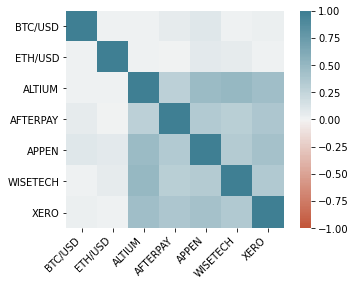

In [30]:
# Plot the correlation heatmap
mixed1_corr = mixed1_returns.corr()
ax = sns.heatmap(
    mixed1_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [37]:
# Volatility
mixed_vol = 

NameError: name 'weights' is not defined